#### Github Repo: https://github.com/deepklarity/fastai-bert-finetuning.git

### This notebook requires Python >= 3.6 and fastai==1.0.52

## Objective

In this notebook we will finetune pre-trained BERT model on The Microsoft Research Paraphrase Corpus (MRPC). MRPC is a paraphrase identification dataset, where systems aim to identify if two sentences are paraphrases of each other.

## BERT

### Overview: 
1. Trained on BookCorpus and English Wikipedia (800M and 2,500M words respectively).
2. Training time approx. about a week using 64 GPUs.
3. State-Of-The-Art (SOTA) results on SQuAD v1.1 and all 9 GLUE benchmark tasks.

### Architecture:

#### Embedding Layers

<img src="https://i2.wp.com/mlexplained.com/wp-content/uploads/2019/01/Screen-Shot-2019-01-04-at-3.32.48-PM.png?w=1128">

- Token embeddings, Segment embeddings and Position embeddings. 
- [SEP] token to mark the end of a sentence.
- [CLS] token at the beginning of the input sequence, to be used only if classifying.

- The convention in BERT is:

(a) For sequence pairs:
 tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
 
 type_ids:   0   0  0    0    0     0      0   0    1  1  1   1  1   1
 
(b) For single sequences:
 tokens:   [CLS] the dog is hairy . [SEP]
 
 type_ids:   0   0   0   0  0     0   0

Where "type_ids" are used to indicate whether this is the first
sequence or the second sequence. The embedding vectors for `type=0` and
`type=1` were learned during pre-training and are added to the wordpiece
embedding vector (and position vector). This is not *strictly* necessary
since the [SEP] token unambigiously separates the sequences, but it makes
it easier for the model to learn the concept of sequences.
        
- For classification tasks, the first vector (corresponding to [CLS]) is
used as as the "sentence vector". The  first  token  of  every  sequence  is  always  the  special  classification  embedding([CLS]). The  final  hidden  state  (i.e.,  out-put of Transformer) corresponding to this token  is  used  as  the  aggregate  sequence  rep-resentation for classification tasks. For non-classification tasks, this vector is ignored.

**Note that this only makes sense because the entire model is fine-tuned.** 

BERT is bidirectional, the [CLS] is encoded including all representative information of all tokens through the multi-layer encoding procedure. The representation of [CLS] is individual in different sentences. [CLS] is later fine-tuned on the downstream task. Only after fine-tuning, [CLS] aka the first token can be a meaningful representation of the whole sentence. [Link](https://github.com/google-research/bert/issues/196)

#### Encoders

<img src="http://jalammar.github.io/images/bert-base-bert-large-encoders.png">

BERT BASE (12 encoders) and BERT LARGE (24 encoders)

#### Training

1. **Masked LM (MLM)**: Before feeding word sequences into BERT, 15% of the words in each sequence are replaced with a [MASK] token.

    Training the language model in BERT is done by predicting 15% of the tokens in the input, that were randomly picked. 

    These tokens are pre-processed as follows — 80% are replaced with a “[MASK]” token, 10% with a random word, and 10% use the original word. The model then attempts to predict the original value of the masked words, based on the context provided by the other, non-masked, words in the sequence.

2. **Next Sentence Prediction (NSP)**: In the BERT training process, the model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document. 

### Pre-trained Model

We will use op-for-op PyTorch reimplementation of Google's BERT model provided by pytorch-pretrained-BERT library. Refer the Github repo for more info: https://github.com/huggingface/pytorch-pretrained-BERT 

In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
! pip install -r requirements.txt

In [3]:
import csv
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
import utils, bert_fastai, bert_helper

In [4]:
# Seed random generators so all model runs are reproducible

utils.seed_everything()

### Using BERT with fastai

There are three things we need to be careful of when using BERT with fastai:

   1. BERT uses its own wordpiece tokenizer.
    
   [WordPiece](https://stackoverflow.com/questions/55382596/how-is-wordpiece-tokenization-helpful-to-effectively-deal-with-rare-words-proble/55416944#55416944) is a commonly used technique to segment words into subword-level in NLP tasks. In this approach an out of vocabulary word is progressively split into subwords and the word is then represented by a group of subwords. Since the subwords are part of the vocabulary, we have learned representations n context for these subwords and the context of the word is simply the combination of the context of the subwords. For more details regarding this approach please refer [Neural Machine Translation of Rare Words with Subword Units](https://arxiv.org/pdf/1508.07909)
       
   **How does this help?**

  Imagine that the model sees the word walking. Unless this word occurs at least a few times in the
training corpus, the model can't learn to deal with this word very well. However, it may have the
words walked, walker, walks, each occurring only a few times. Without subword segmentation, all these
words are treated as completely different words by the model.
However, if these get segmented as walk@@ ing, walk@@ ed, etc., notice that all of them will now have
walk@@ in common, which will occur much frequently while training, and the model might be able to
learn more about it.
   
   2. BERT needs [CLS] and [SEP] tokens added to each sequence.
    
  For classification tasks we need to add [CLS] token before every input sequence.
[SEP] token is used to separate sentences.
    
   3. BERT uses its own pre-built vocabulary.


### Dataset

MRPC dataset a text file containing 5800 pairs of sentences which have been extracted from news sources on the web, along with human annotations indicating whether each pair captures a paraphrase/semantic equivalence relationship. The column named **Quality** indicates whether the sentences are similar (1) or not (0). **"#1 String" and "#2 String"** columns contain the sentences.

In [5]:
# https://www.microsoft.com/en-us/download/details.aspx?id=52398
# Microsoft Research Paraphrase Corpus
TASK='MRPC'
DATA_ROOT = Path(".")
label_col = "Quality"
text_cols = ["#1 String", "#2 String"]


In [6]:
# Execute script to download MRPC data and create train.csv and test.csv

! python download_glue_data.py --data_dir='glue_data' --tasks=$TASK --test_labels=True

Processing MRPC...
Local MRPC data not specified, downloading data from https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt
	Completed!


In [7]:
train_df = pd.read_csv(DATA_ROOT / "glue_data" / "MRPC" / "train.tsv", sep = '\t', quoting=csv.QUOTE_NONE)
train_df.head()

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr..."
1,0,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ..."
3,0,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set..."
4,1,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...


In [8]:
test_df = pd.read_csv(DATA_ROOT / "glue_data" / "MRPC" / "test.tsv", sep = '\t', quoting=csv.QUOTE_NONE)
test_df.head()

,index,Quality,#1 ID,#2 ID,#1 String,#2 String
0,0,1,1089874,1089925,"PCCW 's chief operating officer , Mike Butcher...",Current Chief Operating Officer Mike Butcher a...
1,1,1,3019446,3019327,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...
2,2,1,1945605,1945824,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...
3,3,0,1430402,1430329,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...
4,4,0,3354381,3354396,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...


In [9]:
print(f"Number of Training records={len(train_df)}")
print(f"Number of Test records={len(test_df)}")

Number of Training records=3668
Number of Test records=1725


In [10]:
def sample_sentences(quality, n=5):
    ctr = 0
    for row in train_df.query(f'Quality=={quality}').itertuples():
        print(f"1. {row[4]}\n2. {row[5]}")
        print("="*100)
        ctr += 1
        if n==ctr:
            break


In [11]:
# Different sentences samples            
sample_sentences(0)

1. Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .
2. Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .
1. Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .
2. Tab shares jumped 20 cents , or 4.6 % , to set a record closing high at A $ 4.57 .
1. The Nasdaq had a weekly gain of 17.27 , or 1.2 percent , closing at 1,520.15 on Friday .
2. The tech-laced Nasdaq Composite .IXIC rallied 30.46 points , or 2.04 percent , to 1,520.15 .
1. That compared with $ 35.18 million , or 24 cents per share , in the year-ago period .
2. Earnings were affected by a non-recurring $ 8 million tax benefit in the year-ago period .
1. Shares of Genentech , a much larger company with several products on the market , rose more than 2 percent .
2. Shares of Xoma fell 16 percent in early trade , while shares of Genentech , a much larger company with se

In [12]:
# Similar sentences samples            
sample_sentences(1)

1. Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .
2. Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
1. They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .
2. On June 10 , the ship 's owners had published an advertisement on the Internet , offering the explosives for sale .
1. The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .
2. PG & E Corp. shares jumped $ 1.63 or 8 percent to $ 21.03 on the New York Stock Exchange on Friday .
1. Revenue in the first quarter of the year dropped 15 percent from the same period a year earlier .
2. With the scandal hanging over Stewart 's company , revenue the first quarter of the year dropped 15 percent from the same period a year earlier .
1. The DVD-CCA then appealed to the state Supreme Court .
2. The DVD CCA appealed that 

### Setup code for training

In [13]:
# Specify BERT configs

config = utils.Config(
    bert_model_name="bert-base-uncased",
    num_labels=2, # 0 or 1
    max_lr=2e-5,
    epochs=3,
    batch_size=32,
    max_seq_len=128
)

Refer [A Tutorial to Fine-Tuning BERT with Fast AI](http://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) for deeper understanding of the code changes required for FastAI

In [14]:
fastai_tokenizer = bert_fastai.FastAITokenizer(model_name=config.bert_model_name, max_seq_len=config.max_seq_len)

Now, we can build the databunch using the tokenizer we build above. Notice we're passing the `include_bos=False` and `include_eos=False` options. This is to prevent fastai from adding its own Start-Of-Sentence (SOS)/End-Of-Sentence (EOS) tokens that will interfere with BERT's SOS/EOS tokens.

In [15]:
databunch = TextDataBunch.from_df(".", train_df=train_df, valid_df=test_df,
                  tokenizer=fastai_tokenizer.bert_tokenizer(),
                  vocab=fastai_tokenizer.fastai_bert_vocab(),
                  include_bos=False,
                  include_eos=False,
                  text_cols=text_cols,
                  label_cols=label_col,
                  bs=config.batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )


In [16]:
# Show wordpiece tokenized data

for i in range(5): 
    print(f"Original==> {train_df.loc[i][text_cols[0]]},{train_df.loc[i][text_cols[1]]}\n\nTokenized==>. {databunch.x[i]}")
    print("="*100)

Original==> Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .,Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .

Tokenized==>. [CLS] am ##ro ##zi accused his brother , whom he called " the witness " , of deliberately di ##stor ##ting his evidence . referring to him as only " the witness " , am ##ro ##zi accused his brother of deliberately di ##stor ##ting his evidence . [SEP]
Original==> Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .,Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .

Tokenized==>. [CLS] yu ##ca ##ip ##a owned dominic ##k ' s before selling the chain to safe ##way in 1998 for $ 2 . 5 billion . yu ##ca ##ip ##a bought dominic ##k ' s in 1995 for $ 69 ##3 million and sold it to safe ##way for $ 1 . 8 billion in 1998 . [SEP]
Original==> They had published an adver

# Model

Now with the data in place, we will prepare the model. Again, the pytorch-pretrained-bert package gives us a sequence classifier based on BERT straight out of the box. We also build FastAI `Learner`.

In [17]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification


bert_model = BertForSequenceClassification.from_pretrained(
    config.bert_model_name, num_labels=config.num_labels)

learner = bert_fastai.BertLearner(databunch,
                                  bert_model,
                                  metrics=[accuracy])

learner.callbacks.append(ShowGraph(learner))


Let's print the accuracy and f1_score of the pre-trained model on this dataset

In [18]:
preds, pred_values, true_labels = learner.get_predictions()
learner.print_metrics(preds, pred_values, true_labels)

Accuracy=0.33855071663856506, f1_score=0.013828867761452032


Interpret the results

In [19]:
txt_ci = TextClassificationInterpretation.from_learner(learner)

In [20]:
utils.custom_show_top_losses(txt_ci, test_df, text_cols, 5)

Index,Original Text,Tokenized,Prediction,Actual,Loss,Probability
236,"Results of the 2001 Aboriginal Peoples Survey released yesterday by Statistics Canada suggest living standards have improved but still lag for those off reserves .,The 2001 Aboriginal Peoples Survey released Wednesday by Statistics Canada says living standards have improved but still lag for the Inuit and those who leave their often impoverished reserves .",[CLS] results of the 2001 aboriginal peoples survey released yesterday by statistics canada suggest living standards have improved but still la ##g for those off reserves . the 2001 aboriginal peoples survey released wednesday by statistics canada says living standards have improved but still la ##g for the inuit and those who leave their often impoverished reserves . [SEP],0,0,1.37,0.75
1693,"The new orders index rose to 52.2 percent from 51.9 percent in May .,The New Orders Index rose by 0.3 percentage points from 51.9 percent in May to 52.2 percent in June .",[CLS] the new orders index rose to 52 . 2 percent from 51 . 9 percent in may . the new orders index rose by 0 . 3 percentage points from 51 . 9 percent in may to 52 . 2 percent in june . [SEP],0,1,1.37,0.25
980,"The two companies said PowderJect 's strong U.S. position would complement Chiron 's European presence .,PowderJect 's strong U.S. position will complement Chiron 's European presence , analysts said .","[CLS] the two companies said powder ##ject ' s strong u . s . position would complement chi ##ron ' s european presence . powder ##ject ' s strong u . s . position will complement chi ##ron ' s european presence , analysts said . [SEP]",0,1,1.36,0.26
1487,"A Global Crossing spokeswoman and a Pentagon spokesman declined to comment .,A Global Crossing representative had no immediate comment .",[CLS] a global crossing spoke ##sw ##oman and a pentagon spokesman declined to comment . a global crossing representative had no immediate comment . [SEP],0,0,1.35,0.74
1568,"Another shooting linked to the spree occurred Nov. 11 at Hamilton Central Elementary in Obetz , about two miles from the freeway .,The latest shooting linked to the spree was a Nov. 11 shooting at Hamilton Township Elementary School in Obetz , about two miles from the freeway .","[CLS] another shooting linked to the sp ##ree occurred nov . 11 at hamilton central elementary in obe ##tz , about two miles from the freeway . the latest shooting linked to the sp ##ree was a nov . 11 shooting at hamilton township elementary school in obe ##tz , about two miles from the freeway . [SEP]",0,1,1.35,0.26


epoch,train_loss,valid_loss,accuracy,time
0,0.610131,0.565410,0.710145,00:27
1,0.473887,0.412696,0.817391,00:26
2,0.329955,0.408737,0.821449,00:27


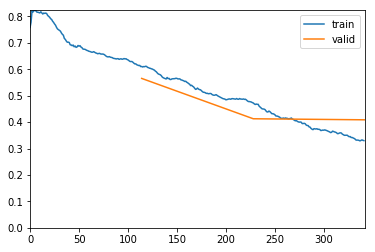

In [21]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

In [22]:
preds, pred_values, true_labels = learner.get_predictions()
learner.print_metrics(preds, pred_values, true_labels)

Accuracy=0.8214492797851562, f1_score=0.8666666666666667


In [23]:
txt_ci = TextClassificationInterpretation.from_learner(learner)

In [24]:
utils.custom_show_top_losses(txt_ci, test_df, text_cols, 10)

Index,Original Text,Tokenized,Prediction,Actual,Loss,Probability
996,"The 2 1 / 2 -ton probe will plunge into the thick Jovian atmosphere today at 3 : 49 p.m. Eastern time , disintegrating moments later from the friction generated by its 108,000-mph free-fall .,The 2 1 / 2-ton probe will plunge into the thick Jovian atmosphere today at 1 : 49 p.m. MDT , disintegrating moments later from the friction generated by its 108,000 mph free-fall .","[CLS] the 2 1 / 2 - ton probe will plunge into the thick jo ##vian atmosphere today at 3 : 49 p . m . eastern time , di ##sin ##te ##grating moments later from the friction generated by its 108 , 000 - mph free - fall . the 2 1 / 2 - ton probe will plunge into the thick jo ##vian atmosphere today at 1 :",1,1,3.65,0.97
436,"Iran has yet to sign an additional protocol to the NPT treaty which would allow U.N. inspections at short notice .,Iran has yet to sign an additional protocol to the Nuclear Non-Proliferation Treaty , which it signed in 1970 , that would allow IAEA inspections at short notice .","[CLS] iran has yet to sign an additional protocol to the np ##t treaty which would allow u . n . inspections at short notice . iran has yet to sign an additional protocol to the nuclear non - proliferation treaty , which it signed in 1970 , that would allow ia ##ea inspections at short notice . [SEP]",1,1,3.61,0.97
569,"Senate Minority Leader Tom Daschle , D-S.D. , is leading the opposition .,"" I think it will pass , "" Senate Minority Leader Tom Daschle , D-S.D. , said in Washington .","[CLS] senate minority leader tom das ##ch ##le , d - s . d . , is leading the opposition . "" i think it will pass , "" senate minority leader tom das ##ch ##le , d - s . d . , said in washington . [SEP]",1,0,3.59,0.03
779,"Casteen has been under pressure from Gov. Mark R. Warner and other state officials to do whatever he could to protect Virginia Tech 's athletic viability .,Virginia Gov. Mark R. Warner has been urging other state officials to do whatever they could to protect Virginia Tech 's interests .",[CLS] caste ##en has been under pressure from gov . mark r . warner and other state officials to do whatever he could to protect virginia tech ' s athletic via ##bility . virginia gov . mark r . warner has been urging other state officials to do whatever they could to protect virginia tech ' s interests . [SEP],1,1,3.59,0.97
192,"His chief lawyer , Mahendradatta , said Bashir was mentally prepared for a heavy sentencing demand and felt the Marriott bombing would affect the decision .,A lawyer for Bashir , Mahendradatta , said earlier his client was mentally prepared for a heavy sentencing demand and had felt the Marriott bombing would affect the decision .","[CLS] his chief lawyer , ma ##hend ##rada ##tta , said bash ##ir was mentally prepared for a heavy sentencing demand and felt the marriott bombing would affect the decision . a lawyer for bash ##ir , ma ##hend ##rada ##tta , said earlier his client was mentally prepared for a heavy sentencing demand and had felt the marriott bombing would affect the decision . [SEP]",1,1,3.56,0.97
91,"They were at Raffles Hospital over the weekend for further evaluation .,They underwent more tests over the weekend , and are now warded at Raffles Hospital .","[CLS] they were at raf ##fles hospital over the weekend for further evaluation . they underwent more tests over the weekend , and are now ward ##ed at raf ##fles hospital . [SEP]",1,1,3.54,0.97
589,"In that case , the court held that Cincinnati had violated the First Amendment in banning only the advertising pamphlets in the interest of aesthetics .,In that case , the court held that the city of Cincinnati had violated the First Amendment in banning , in the interest of aesthetics , only the advertising pamphlets .","[CLS] in that case , the court held that cincinnati had violated the first amendment in banning only the advertising pamphlets in the interest of aesthetics . in that case , the court held that the city

#### Next Steps

- There's major improvement in the accuracy and loss by just running for few epochs. We can improve the model further to acc = 0.8504901960784313 and f1 = 0.8974789915966387 by using the techniques mentioned in the original BERT paper. Refer to https://github.com/huggingface/pytorch-pretrained-BERT#mrpc for details.
- Use BertAdam Optimizer [BertAdam](https://github.com/huggingface/pytorch-pretrained-BERT/blob/694e2117f33d752ae89542e70b84533c52cb9142/README.md#optimizers)
[Is BertAdam better](https://github.com/huggingface/pytorch-pretrained-BERT/issues/420)

- Finetune BERT on Quora insincere questions.
- Explore LAMB Optimizer: https://forums.fast.ai/t/lamb-optimizer/43582/19
- Compare with ULMFiT, gpt-2